# AGC - Area under Gain Curves

We introduce the Python package **agc** which is useful for the evaluation of **binary classifiers** under a commonly encountered scenario where **limited resources** are available to validate the top-scoring results. In such cases, we seek a classifier that retrieves as many positive cases as possible amongst the top-scoring points, and we are less concerned with the overall performance.

To that effect, we introduce the **Normalized Truncates Area under Gain Curves (AGC)** measure, and compare it with well known measures such as the **AUC** (area under the ROC curve), Precision, and Average Precision (**AP**).

This is illustrated via a story where we compare outputs from 3 hypothetical algorithms. 


In [1]:
## some standard packages
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve
import matplotlib.pyplot as plt
%matplotlib inline

## agc package; install via: pip install agc
from agc import * 


# The context

Let's assume we have 10M files, 10k of which are labelled as malware (label = 1). The other files are assumed benign with label = 0. We want to compare classifiers used to identify malware files. In the cell below, we build the dataset and 3 hypothetical outputs from 3 different classification algorithms. We assume that each algorithm returns a score in the interval [0,1] for each file.

In the cell below:
* y_true: labels for the dataset (a.k.a. ground truth)
* p1, p2, p3: scores from the 3 algorithms, respectively.


In [2]:
## the "dataset" with 10k "positive" labels
n = 10000000
pos = 10000
y_true = np.repeat(0,n-pos)
for i in np.random.choice(n//100, pos, False):
    y_true[i] = 1
y_true = np.concatenate((np.repeat(1,pos),np.repeat(0,n-pos)))

## output from 3 hypothetical algorithms
## (algo 1)
K = 100000
p1 = np.concatenate((np.random.uniform(.8,1,pos),np.random.uniform(.8,1,K-pos),np.random.uniform(0,.9,n-K)))
## (algo 2)
p2 = np.concatenate((np.random.uniform(.9,1,150),np.random.uniform(.8,.9,250),np.random.uniform(.7,.8,100),
                    np.random.uniform(.6,.75,pos-500),np.random.uniform(.9,1,350),np.random.uniform(.8,.9,250),
                    np.random.uniform(.7,.8,900),np.random.uniform(.1,.75,n-pos-1500)))
## (algo 3)
p3 = np.concatenate((np.random.uniform(.9,1,250),np.random.uniform(.8,.9,150),np.random.uniform(.7,.8,100),
                    np.random.uniform(.6,.75,pos-500),np.random.uniform(.9,1,250),np.random.uniform(.8,.9,350),
                    np.random.uniform(.7,.8,900),np.random.uniform(.1,.75,n-pos-1500)))


# Step 1 - AUC

The area under ROC curve, or AUC, is a commonly used measure of performance, often the only one used. 
From the results below, we see that algorithm 1 is the best w.r.t. AUC, and all values are quite high. This leads us to think that we have 3 very strong classifiers!

In [3]:
## step 1 - compare AUCs
print('algo 1:',roc_auc_score(y_true, p1))
print('algo 2:',roc_auc_score(y_true, p2))
print('algo 3:',roc_auc_score(y_true, p3))


algo 1: 0.967377535865866
algo 2: 0.8906596763863865
algo 3: 0.8894806957357357


# Step 2 - AP

But wait, we remember from our data science class that under class imbalance, which is clearly the case here, we should use the average precision (AP) measure instead. 
From the results below, we see much smaller values, so maybe we are not doing that great after all; however, algorithm 1 still is the winner, so this should be our choice, should it?


In [4]:
## step 2 -  but for data with class imbalance, AP is recommended, let's see
print('algo 1:',average_precision_score(y_true, p1))
print('algo 2:',average_precision_score(y_true, p2))
print('algo 3:',average_precision_score(y_true, p3))
## scores are much lower now, but algo 1 still seems the best choice

algo 1: 0.05713149396807394
algo 2: 0.020489802287212304
algo 3: 0.025967287711567134


# Step 3 - Precision

Ok wait, no matter which algorithm we choose, someone will need to look at the top scoring files to confirm those are malware, and this is quite costly. Thus, we have a **limited budget** in terms of what we will be able to verify. We are told that in the best possible scenario, only about **1000** files can be looked at, and this is a very optimistic figure. Then in that case, we decide to simply look at the precision given the top-1000 scoring files for the 3 algorithms.
We now see a very different story below; algorithms 2 and 3 now are the better choices, with the same precision scores. Which one should we select?


In [5]:
## step 3 - limited budget; 
## we will only be able to look at top-1000 files, and this is very optimistic, likely much less
## let's look at precision (or number of hits) in top 1000
T = 1000
x = np.argsort(p1)[-1000:]
print('algo 1:',sum([i<10000 for i in x])/1000)
x = np.argsort(p2)[-1000:]
print('algo 2:',sum([i<10000 for i in x])/1000)
x = np.argsort(p3)[-1000:]
print('algo 3:',sum([i<10000 for i in x])/1000)
## well now, algo 2 or 3 are best, with equal performance; what to do?

algo 1: 0.097
algo 2: 0.4
algo 3: 0.4


# Step 4 - Precision, bis

So from the information we got, 1000 is an optimistic figure and it is likely that a smaller number of files can be reviewed. Let's look at the precision (number or proportion of true positives we recover) for all possible thresholds from 1 to 1000. We plot those results below for the 3 algorithms.
From these plots, we still see that algorithms 2 and 3 are better, but algorithm 3 gets more **early hits**.
It seems that this should be our choice, but is there a **single measure** that would lead us that way, without having to generate all values and look at the plots?


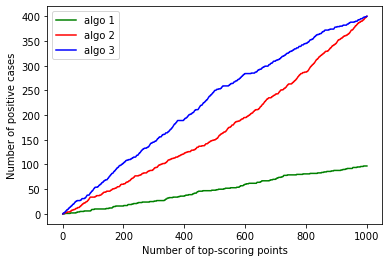

In [6]:
## step 4 - let's look at precision (number of hits) for each values of k<=1000, for the top-k
top1, tpr1, _  = gain_curve(y_true, p1, truncate=1000)
top2, tpr2, _  = gain_curve(y_true, p2, truncate=1000)
top3, tpr3, _  = gain_curve(y_true, p3, truncate=1000)
plt.plot(top1*n,tpr1*pos,color='green',label='algo 1')
plt.plot(top2*n,tpr2*pos,color='red',label='algo 2')
plt.plot(top3*n,tpr3*pos,color='blue',label='algo 3')
mt = max(top1)
plt.plot([0,mt],[0,mt],color='black')
plt.xlabel('Number of top-scoring points')
plt.ylabel('Number of positive cases')
plt.legend();


# Step 5 - AGC

Indeed there is! Gain curves are not used as much as ROC or precision-recall curves, but for the scenario we have here, they are a perfect choice.
With gain curves, we replace the false positive rate in x-axis of ROC with the number of top-scoring points considered, so when we look at top-$k$, the x-axis is $k/N$, where $N$ is the total number of points, and the y-axis is the true positive rate.
Below we draw the gain curve for algorithm 3 (shown in red); the black line is expected results under random ranking and the blue line is the best possible curve.

In the next cell, we compute the AGC (area under the gain curves) for the 3 algorithms, which show similar results to the AUC.


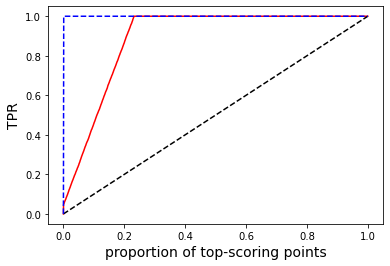

In [7]:
## step 5 - gain curve and AGC
fpr, tpr, thresholds = gain_curve(y_true, p3)
plt.plot(fpr,tpr,color='red')
plt.plot([0,1],[0,1],'--',color='black')
r = pos/n ## proportion of positives overall
plt.plot([0,r,1],[0,1,1],'--',color='blue'); ## max
plt.xlabel('proportion of top-scoring points',fontsize=14)
plt.ylabel('TPR',fontsize=14);

In [8]:
## We can compute the AGC, which is quite similar to AUC
print('algo 1:',agc_score(y_true, p1, normalized=False))
print('algo 2:',agc_score(y_true, p2, normalized=False))
print('algo 3:',agc_score(y_true, p3, normalized=False))


algo 1: 0.9673938552576288
algo 2: 0.8907143738969485
algo 3: 0.8895359830315157


# Step 6 - Denouement ... truncated, normalized AGC!

Given the nature of the x-axis with gain curves, we can easily truncate it so that we only consider the top-$k$ scoring points. Moreover, given: 
* AGC(k): area under the gain curve truncated at $k$
* R(k): **expected** area under the gain curve truncated at $k$ under random classification
* M(k): **maximal** possible area under the gain curve truncated at $k$

we define the **normalized** area under the gain curve **truncated** at $k$ as:

* AGC'(k) = (AGC(k)-R(k)) / (M(k)-R(k))

This represents the proportion of possible gain over random that we achieved; note that it can be negative if we do worse than random.

Below, we compute AGC'(1000) for the 3 algorithms, with results that are well aligned with what we saw earlier in the precision plots.


In [9]:
## AGC'(1000) for the 3 algorithms
print('algo 1:',agc_score(y_true, p1, normalized=True, truncate=1000))
print('algo 2:',agc_score(y_true, p2, normalized=True, truncate=1000))
print('algo 3:',agc_score(y_true, p3, normalized=True, truncate=1000))


algo 1: 0.09603903903903904
algo 2: 0.34544344344344347
algo 3: 0.44906306306306304


# Appendix - Speed tests

This is all very nice indeed, but how quickly can we compute AGC'(k) when $N$, the total number of points, is large? 
Does the value at which we truncate matter?
In the first cell below, we look at the same example ($N$ = 10M), truncating at various values, using the results for algorithm 3. We see that the truncation value is not relevant, not surprizing as the bottleneck is to sort the whole vector of scores anyways.
In the next cell, we look at a different experiment where we vary the size $N$ of the dataset from $2^{16}$ to $2^{27}$ inclusively. We do 10 runs for each value of $N$ and plot the averages on a log-log scale.
We see that even for datasets as large as $N = 2^{27} = 134,217,728$, run time is under $2^6 = 64$ seconds (on a MacBook Pro).


In [10]:
## how fast is it to compute AGC'(k) when we vary k?
import time
X = [100,1000,10000,100000,1000000]
for t in X:
    start = time.time()
    s = agc_score(y_true, p3, normalized=True, truncate=t)
    print(t,':',time.time()-start,'sec')


100 : 2.567754030227661 sec
1000 : 2.575284957885742 sec
10000 : 2.5659730434417725 sec
100000 : 2.5834171772003174 sec
1000000 : 2.583716869354248 sec


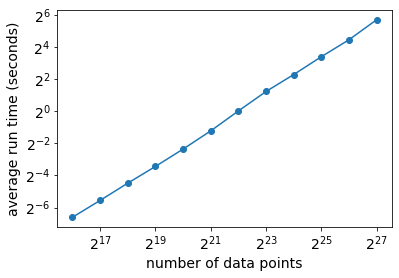

In [11]:
## now we vary N, with 0.1% positives, random classifier, truncate at 1%
x = []
y = []
for i in [16,17,18,19,20,21,22,23,24,25,26,27]: ## 
    n = int(2**i)
    x.append(n)
    pos = n//1000
    y_tr = np.concatenate((np.repeat(1,pos),np.repeat(0,n-pos)))
    ctr = 0
    for z in range(10):
        proba = np.random.random(n)
        start = time.time()
        s = agc_score(y_tr, proba, normalized=True, truncate=n//100)
        ctr += (time.time()-start)    
    y.append(ctr/10)

## plot
plt.loglog(x[:12],y[:12],'o-',base=2)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel('number of data points', fontsize=14)
plt.ylabel('average run time (seconds)', fontsize=14);
